In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline
from edfreader import read_edf
from aSPEM import aSPEM
import bayesianchangepoint as bcp


# the switching binomial generative model


In [2]:
t_titre = 35
t_label = 25
fig_width= 15

In [3]:
timeStr = '2017-09-20_151043'
observer = 'LB'
mode = 'enregistrement'

In [4]:
file = os.path.join('data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']

# TODO extract params from aSPEM.py + verify
p = exp['p']
tau = N_trials/20.
h = 1/tau
seed = 51

## evaluating the best hazard rate using a likelihood score

In [6]:
N_scan = 1 #100

hs = h*np.logspace(-1, 1, N_scan)
modes = ['expectation', 'max']
score = np.zeros((len(modes), N_scan, N_blocks))
for i_mode, mode in enumerate(modes):
    for i_block in range(N_blocks):
        o = p[:, i_block, 0]
        for i_scan, h_ in enumerate(hs):
            p_bar, r, beliefs = bcp.inference(o, h=h_, p0=.5)
            p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
            score[i_mode, i_scan, i_block] = np.mean(np.log2(1.e-12+bcp.likelihood(o, p_hat, r_hat)))

In [7]:
def plot_tous(p, score, pause=None, mode='expectation', max_run_length=150, fig_width=15, t_titre=35, t_label=25):
    
    for block in range(len(p[0][0])) :
        o = p[:, block, 0]
        p_true = p[:, block, 1]
        
        N_trials = o.size
        fig_width= fig_width
        fig, axs = plt.subplots(3, 1, figsize=(fig_width, (fig_width)/((1.6180*6)/2)))
        
        axs[0] = plt.subplot(221)
        axs[1] = plt.subplot(223)
        axs[2] = plt.subplot(143)
        plt.suptitle('Block %s'%(block), fontsize=t_label/2, y=1.05, x=0, ha='left')
        
        axs[0].step(range(N_trials), o, lw=1, alpha=.2, c='k')
        axs[0].step(range(N_trials), p_true, lw=1, alpha=.5, c='k')
        axs[0].fill_between(range(N_trials), np.zeros_like(o), o, lw=.5, alpha=.2, facecolor='k', step='pre')
        axs[0].fill_between(range(N_trials), np.zeros_like(p_true), p_true, lw=.5, alpha=.2, facecolor='k', step='pre')

        
        from scipy.stats import beta
        #---------------------------------------------------------------------------
        if pause is not None :
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=h, p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
                for i_trial in range(50):#N_trials):
                    p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])
                axs[0].plot(np.arange(liste[a], liste[a+1]), p_hat, c='r',  lw=1)
                axs[0].plot(np.arange(liste[a], liste[a+1]), p_sup, 'r--', lw=1)
                axs[0].plot(np.arange(liste[a], liste[a+1]), p_low, 'r--', lw=1)
                axs[0].fill_between(np.arange(liste[a], liste[a+1]), p_sup, p_low, lw=.5, alpha=.2, facecolor='r')
                
                axs[1].imshow(np.log(beliefs[:max_run_length, :]+ 1.e-5), cmap='Greys',
                              extent=(liste[a],liste[a+1], np.max(r), np.min(r)))
                
                axs[1].plot(np.arange(liste[a], liste[a+1]), r_hat, lw=1, alpha=.9, c='r')
            
            for a in range(2):
                axs[a].bar(50, 140 + 2*(.05*140), bottom=-.05*140, color='k', width=0, linewidth=2)
                axs[a].bar(100, 140 + 2*(.05*140), bottom=-.05*140, color='k', width=0, linewidth=2)
                axs[a].bar(150, 140 + 2*(.05*140), bottom=-.05*140, color='k', width=0, linewidth=2)
        else :
            p_bar, r, beliefs = bcp.inference(o, h=h, p0=.5)
            p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
            
            p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
            for i_trial in range(N_trials):
                p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])

            axs[0].plot(range(N_trials), p_hat, lw=1, alpha=.9, c='r')
            axs[0].plot(range(N_trials), p_sup, 'r--', lw=1, alpha=.9)
            axs[0].plot(range(N_trials), p_low, 'r--', lw=1, alpha=.9)
            axs[0].fill_between(range(N_trials), p_low, p_sup, lw=.5, alpha=.2, facecolor='r')
            
            axs[1].imshow(np.log(beliefs[:max_run_length, :] + 1.e-5 ), cmap='Greys')
            axs[1].plot(range(N_trials), r_hat, lw=1, alpha=.9, c='r')
        #---------------------------------------------------------------------------

        for i_layer, label in zip(range(2), ['$\hat{P}$ +/- CI', 'belief on r=p(r)']):
            axs[i_layer].set_xlim(0, N_trials)
            axs[i_layer].axis('tight')
            axs[i_layer].set_ylabel(label, fontsize=t_label/2)

        axs[1].set_ylim(-.05*140, 140 + (.05*140))
        axs[1].set_yticks(np.arange(0, 140 + (.05*140), 140/2))

        axs[1].set_xlabel('trials', fontsize=t_label/2);
        axs[0].set_ylim(-.05, 1 + .05)
        axs[0].set_yticks(np.arange(0, 1 + .05, 1/2))

        axs[1].set_xticks([-1, 49, 99,149])
        axs[1].set_xticklabels([0, 50, 100, 150], ha='left')
        axs[0].set_xticks([])
        axs[0].set_xticklabels([])
        if mode=='expectation' :
            i_mode = 0
        else :
            i_mode = 1

        axs[2].plot(hs, np.mean(score[i_mode, ...], axis=1), c='r', label=mode)
        axs[2].fill_between(hs,np.std(score[i_mode, ...], axis=1)+np.mean(score[i_mode, ...], axis=1), -np.std(score[i_mode, ...], axis=1)+np.mean(score[i_mode, ...], axis=1),  lw=.5, alpha=.2, facecolor='r', step='mid')

        axs[2].vlines(h, ymin=np.nanmin(score), ymax=np.nanmax(score), lw=2, label='true')
        axs[2].set_xscale("log")

        axs[2].set_xlabel('Hazard rate', fontsize=t_label/2)
        axs[2].set_ylabel('Mean log-likelihood (bits)', fontsize=t_label/2)
        axs[2].legend(frameon=False, loc="lower left")

        for i_layer in range(len(axs)) :      
            axs[i_layer].xaxis.set_ticks_position('bottom')
            axs[i_layer].yaxis.set_ticks_position('left')

        fig.tight_layout()
        plt.subplots_adjust(hspace=0.1)
        plt.show()
    return fig, axs

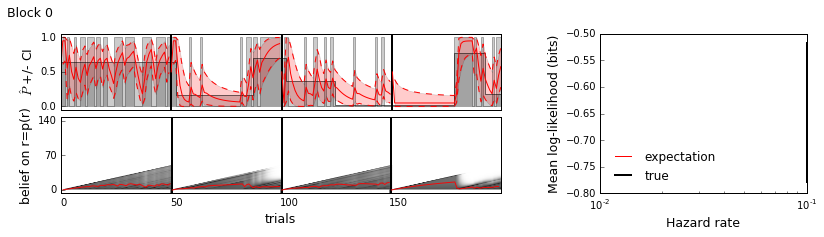

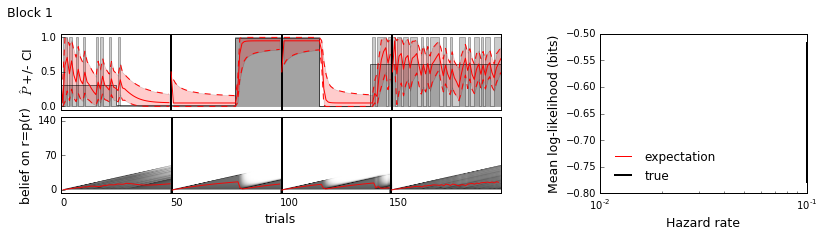

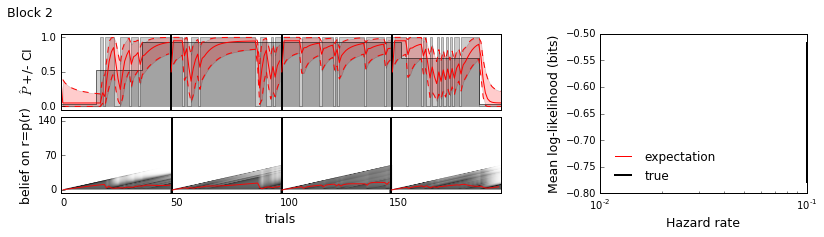

In [8]:
fig, axs = plot_tous(p, score, pause=True)

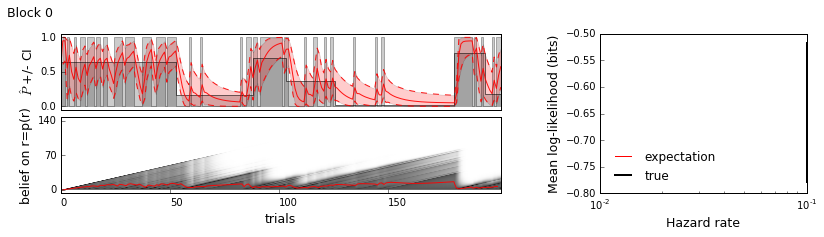

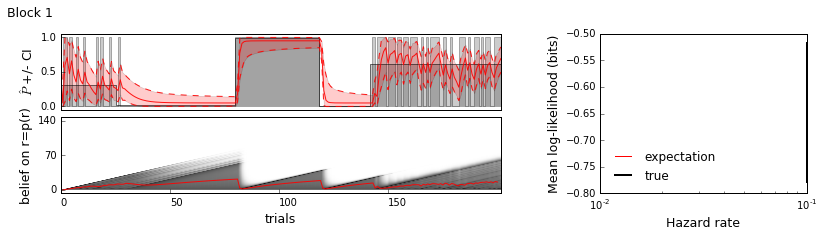

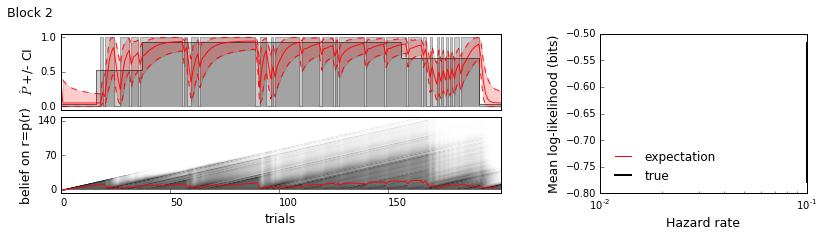

In [9]:
fig, axs = plot_tous(p, score)

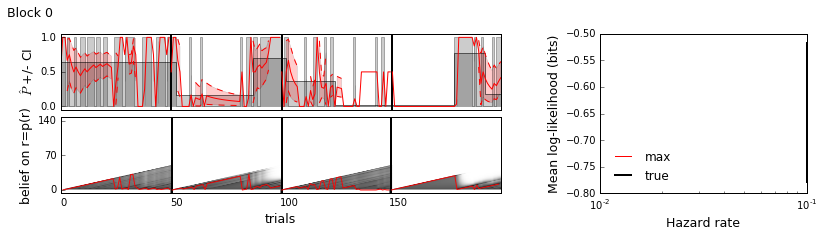

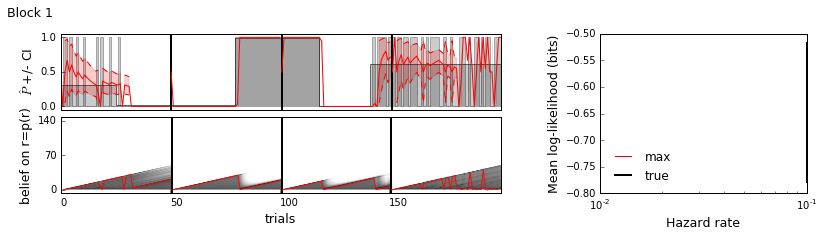

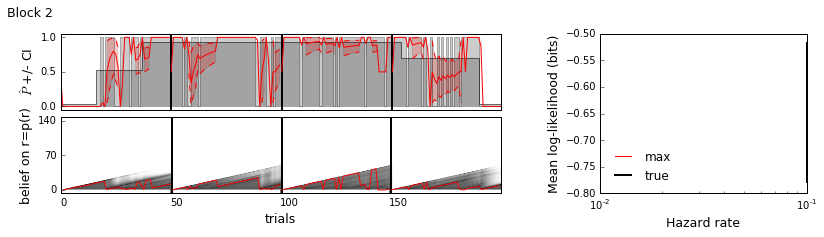

In [10]:
fig, axs = plot_tous(p, score, mode='max', pause=True)

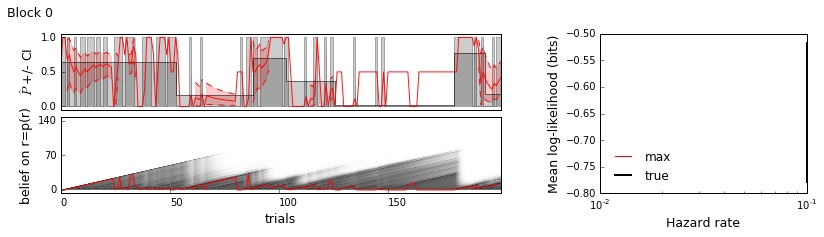

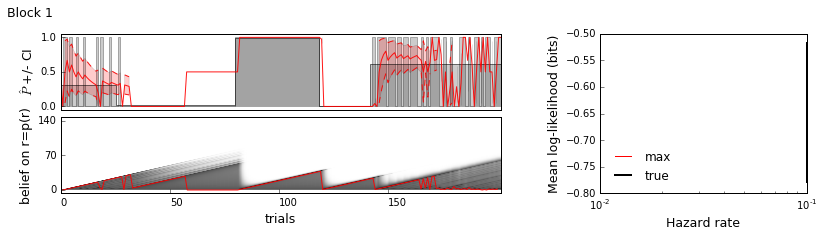

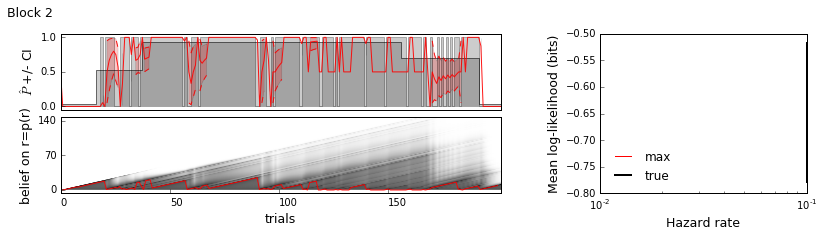

In [11]:
fig, axs = plot_tous(p, score, mode='max')

## Figure Poster

In [12]:
import matplotlib.gridspec as gridspec

In [39]:
def fifig(p, block, max_run_length=150, fig_width=15, t_titre=35, t_label=25):

    fig, axs = plt.subplots(5, 1, figsize=(fig_width, (fig_width)/((1.6180))))
    gs1 = gridspec.GridSpec(2, 1)
    gs1.update(left=0, bottom=1/2, right=1, top=1., hspace=0.05)
    axs[0] = plt.subplot(gs1[0])
    axs[1] = plt.subplot(gs1[1])

    gs2 = gridspec.GridSpec(2, 1)
    gs2.update(left=0, bottom=-0.16, right=1, top=(1/2)-0.16, hspace=0.05)
    axs[2] = plt.subplot(gs2[0])
    axs[3] = plt.subplot(gs2[1])
    
    gs3 = gridspec.GridSpec(1, 1)
    gs3.update(left=0, bottom=-(0.82)/1.5, right=1, top=-0.32, wspace=0.05)
    axs[4] = plt.subplot(gs3[0])
    
    block=block
    print('Block', block)
    o = p[:, block, 0]
    p_true = p[:, block, 1]

    N_trials = o.size
    fig_width= fig_width
    
    for x, mode in enumerate(['expectation', 'max']) :
        print(x)
        if x == 0 :
            a=0
        else:
            a=1
        axs[a+x].step(range(N_trials), o, lw=1, alpha=.15, c='k')
        axs[a+x].step(range(N_trials), p_true, lw=1, alpha=.13, c='k')
        axs[a+x].fill_between(range(N_trials), np.zeros_like(o), o, lw=0, alpha=.15, facecolor='k', step='pre')
        axs[a+x].fill_between(range(N_trials), np.zeros_like(p_true), p_true, lw=0, alpha=.13, facecolor='k', step='pre')


        from scipy.stats import beta

        p_bar, r, beliefs = bcp.inference(o, h=h, p0=.5)
        p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
        
        p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
        for i_trial in range(N_trials):
            p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])

        axs[a+x].plot(range(N_trials), p_hat, lw=1.5, c='darkred')
        axs[a+x].plot(range(N_trials), p_sup, c='darkred', ls='--', lw=1.2)
        axs[a+x].plot(range(N_trials), p_low, c='darkred', ls='--', lw=1.2)
        axs[a+x].fill_between(range(N_trials), p_low, p_sup, lw=.5, alpha=.11, facecolor='darkred')

        axs[(a+1)+x].imshow(np.log(beliefs[:max_run_length, :] + 1.e-5 ), cmap='Greys')

        
        
        
        lala = (beliefs[:, 50])
        somme = 0
        for ploup in range(len(lala)):
            somme = somme + ploup * lala[ploup]
        
        axs[4].plot(lala, c='k')
        #axs[4].scatter(np.argmax(lala), np.max(lala), c='r')
        '''axs[4].annotate('max', xy=(np.argmax(lala), np.max(lala)),
             xycoords='data', fontsize=t_label/1., color='darkred', va='bottom',
            xytext=(np.argmax(lala)-10, np.max(lala)+0.01),
             textcoords='data')
        axs[4].annotate('expectation = $\sum_{r=0}^\infty r p(r)$', xy=(100, 0.1),
             xycoords='data', fontsize=t_label/1., color='darkred', va='center',
            xytext=(49, 0.1),
             textcoords='data')
        
        if mode == 'expectation' :
            axs[4].annotate('',
                 xy=(49, 0.1), xycoords=axs[4].transData,
                 xytext=(49, r_hat[50]),
                 textcoords=axs[1].transData,
                 ha="left", va="bottom",
                 arrowprops=dict(arrowstyle="->", color='darkred',
                                      connectionstyle="arc3,rad=0.2",
                                      fc="w"))
            axs[4].annotate('',
                 xy=(20, 0.1), xycoords=axs[4].transData,
                 xytext=(49, r_hat[50]),
                 textcoords=axs[1].transData,
                 ha="left", va="bottom",
                 arrowprops=dict(arrowstyle="-", color='k',
                                      fc="w"))
        else :
            axs[4].annotate('',
                 xy=(np.argmax(lala), np.max(lala)), xycoords=axs[4].transData,
                 xytext=(49, r_hat[50]),
                 textcoords=axs[3].transData,
                 ha="left", va="bottom",
                 arrowprops=dict(arrowstyle="->", color='darkred',
                                      connectionstyle="arc3,rad=-0.2",
                                      fc="w"))
            axs[4].annotate('',
                 xy=(25, 0.05), xycoords=axs[4].transData,
                 xytext=(49, r_hat[50]),
                 textcoords=axs[3].transData,
                 ha="left", va="bottom",
                 arrowprops=dict(arrowstyle="-", color='k',
                                      fc="w"))'''

        axs[4].spines['top'].set_color('none')
        axs[4].spines['right'].set_color('none')
        print(np.max(lala), r_hat[50], somme)
        
        axs[(a+1)+x].plot(range(N_trials), r_hat, lw=1.5, c='r')
        #---------------------------------------------------------------------------

        for i_layer, label in zip(range(2), ['$\hat{P}$ $\pm$ CI', 'belief on r = p(r)']) : # ['$\hat{P}$ +/- CI', 'belief on \nr=p(r)']):
            axs[i_layer+a+x].set_xlim(0, N_trials)
            axs[i_layer+a+x].axis('tight')
            axs[i_layer+a+x].set_ylabel(label, fontsize=t_label/1.5)

            axs[i_layer+a+x].xaxis.set_ticks_position('bottom')
            axs[i_layer+a+x].yaxis.set_ticks_position('left')


        axs[(a+1)+x].bar(49, 140 + (.05*140)+.05*140, bottom=-.05*140, color='firebrick', width=0.5, linewidth=0, alpha=1)
        axs[(a+1)+x].set_ylim(-.05*140, 140 + (.05*140))
        axs[(a+1)+x].set_yticks(np.arange(0, 140 + (.05*140), 140/2))
        axs[(a+1)+x].yaxis.set_tick_params(labelsize=t_label/2)
        axs[(a+1)+x].set_xlabel('Trials', fontsize=t_label);

        axs[a+x].set_ylim(-.05, 1 + .05)
        axs[a+x].set_yticks(np.arange(0, 1 + .05, 1/2))
        axs[a+x].yaxis.set_tick_params(labelsize=t_label/2)

        axs[(a+1)+x].set_xticks([-1, 49, 99,149])
        axs[(a+1)+x].set_xticklabels([0, 50, 100, 150], ha='left', fontsize=t_label/2)
        axs[a+x].set_xticks([])
        axs[a+x].set_xticklabels([])


        if mode=='expectation' :
            i_mode = 0
        else :
            i_mode = 1
        if mode == 'expectation' :

            axs[a+x].set_title('Bayesian change point : expectation $\sum_{r=0}^\infty r p(r)$', x=0.5, y=1.20, fontsize=t_titre)
        else :
            axs[a+x].set_title('Bayesian change point : max(p(r))', x=0.5, y=1.05, fontsize=t_titre)
    
    for i_layer in range(len(axs)) :      
        axs[i_layer].xaxis.set_ticks_position('bottom')
        axs[i_layer].yaxis.set_ticks_position('left')
    
    axs[4].set_xlabel('r$_{50}$', fontsize=t_label/1.5)
    axs[4].set_ylabel('p(r$_{50}$)', fontsize=t_label/1.5)
    axs[4].set_title('Belief on r for trial 50', x=0.5, y=1., fontsize=t_titre/1.2)
    axs[4].xaxis.set_tick_params(labelsize=t_label/1.9)
    axs[4].yaxis.set_tick_params(labelsize=t_label/1.9)
    
    plt.show()

Block 2
0
0.133321314474 9.99262296584 9.99262296584
1
0.133321314474 13 9.99262296584


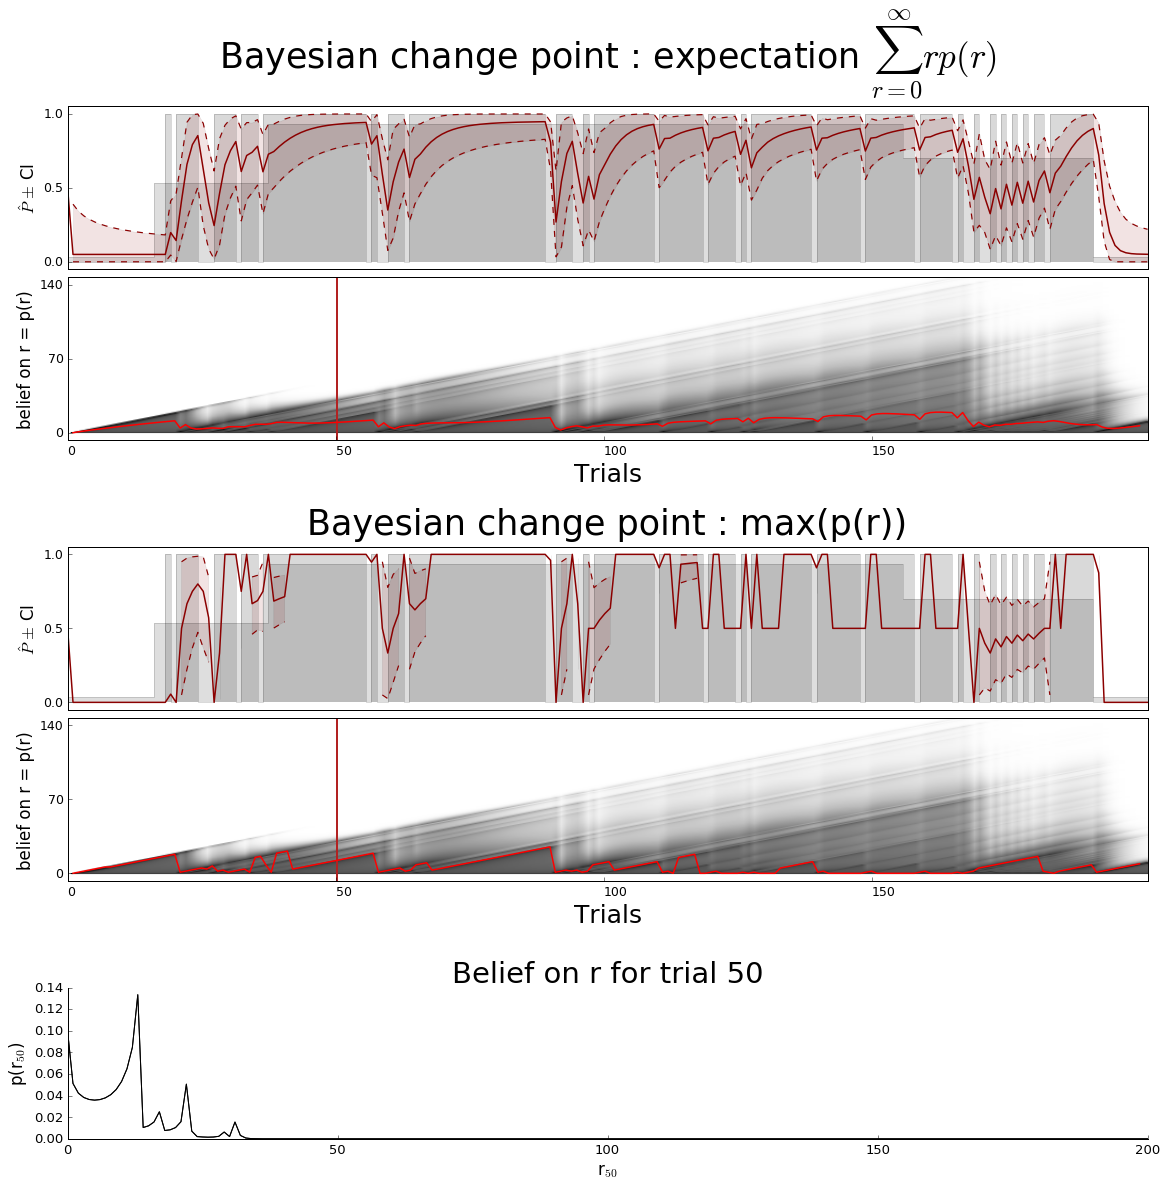

In [40]:
fifig(p, block=2)